###### Data Privacy Enhancing Techniques
<br><br>
<div style="background-color:rgba(128, 128, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">
<p style="font-size:134%;color:Deep Teal;">SC 4125: Developing Data Products</p>
    <p style="font-size:100%;color:Olive;">Module-8: Data Governance/Privacy Issues</p><br>

    
<br> 
by <a href="https://personal.ntu.edu.sg/anwitaman/" style="font-size:100%;color:Deep Teal;">Anwitaman DATTA</a><br>
School of Computer Science and Engineering, NTU Singapore.        
</div>

#### Teaching material
- <a href="M8-DaGov.pdf">.pdf</a> deck of slides (complements the html slides)
- <a href="M8-DaGov.slides.html">.html</a> deck of slides
- <a href="M8-DaGov.ipynb">.ipynb</a> Jupyter notebook

### Disclaimer/Caveat emptor

- Non-systematic and non-exhaustive review
- Illustrative approaches are not necessarily the most efficient or elegant, let alone unique
- This Jupyter notebook is accompanied by a deck of slides discussing Data Governance in general, as well as specific privacy enhancing techniques.

### Acknowledgement

> This module is adapted from workshop <a href="https://github.com/kiprotect/data-privacy-for-data-scientists">training material</a> created by <span style="color:SteelBlue">Andreas Dewes</span> and <span style="color:SteelBlue">Katherine Jarmul</span> from Kiprotect, which they have made available under MIT License. Here's an accompanying talk on <a href="https://www.youtube.com/watch?v=i-embbaJX_A">Data Science Meets Data Protection</a>. 
>
>If anyone reuses the material in the current format as readapted and provided here, please still also attribute the original creators of the content.
>
> If there are any attribution omissions to be rectified, or should anything in the material need to be changed or redacted, the copyright owners are requested to contact me at anwitaman@ntu.edu.sg  

# <span style="color:olivedrab">k-Anonymity</span>

External data (voter registration information) can be used to deanonymyze |  2-Anonymyzed patient data
:-------------------------:|:-------------------------:
<img src="pics/CorrelatableDataTable.png" alt="bigpic" width="300"/>  |  <img src="pics/2Anonym.png" alt="Sampling" width="300"/>
Example from <a href="http://pages.cs.wisc.edu/~lefevre/MultiDim.pdf">Mondrian Multidimensional K-Anonymity</a> by LeFevre et al

In [1]:
# this is a list of the column names in our dataset (the file doesn't contain headers)
names = (
    'age',
    'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    'fnlwgt', # final weight. In other words, this is the number of people the census believes the entry represents.
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

In [2]:
# some fields are categorical and thus they need to be treated accordingly
# note that integers are used to represent some of the categorical data
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))

In [3]:
import pandas as pd
datapath ='data/kiprotectdata/' # change this to adjust relative path
df = pd.read_csv(datapath+"adult.all.txt", sep=", ", header=None, names=names, index_col=False, engine='python')
for name in categorical:
    df[name] = df[name].astype('category')
print(df.shape)
df.sample(10)

(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
38515,37,Private,285637,HS-grad,9,Never-married,Transport-moving,Not-in-family,Black,Male,0,0,50,United-States,<=50k
19744,57,Private,29375,HS-grad,9,Separated,Sales,Not-in-family,Amer-Indian-Eskimo,Female,0,0,35,United-States,<=50k
9584,19,Private,201743,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,26,United-States,<=50k
18273,23,State-gov,35633,Some-college,10,Never-married,Other-service,Not-in-family,White,Male,0,0,50,United-States,<=50k
14838,32,Self-emp-inc,161153,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,1902,55,United-States,>50k
16585,44,Private,192381,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1848,40,United-States,>50k
22570,43,Self-emp-inc,602513,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50k
25297,69,Federal-gov,143849,11th,7,Widowed,Adm-clerical,Not-in-family,White,Female,0,0,20,United-States,<=50k
39942,35,Private,351772,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50k
4431,21,Private,174503,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,30,United-States,<=50k


### Greedy heuristic

#### Helper function: spans of columns of a dataframe

> We first need a function that returns the spans (max-min for numerical columns, number of different values for categorical columns) of all columns for a partition of a dataframe.

In [4]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """    
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [5]:
full_spans = get_spans(df, df.index)
full_spans

{'age': 73,
 'workclass': 9,
 'fnlwgt': 1478115,
 'education': 16,
 'education-num': 15,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital-gain': 99999,
 'capital-loss': 4356,
 'hours-per-week': 98,
 'native-country': 42,
 'income': 2}

#### Helper function: split a dataframe in two partitions based on a `column`

> partition the dataframe, returning two partitions such that
> - all rows with values of a chosen/indicated column `column` below the median are in one partition 
> - all rows with values above or equal to the median are in the other
>     - for categorical data, divide them into two disjoint sets of (roughly) equal number of categories

In [6]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

#### Helper function: Determines if a specific partition has at least k entrees

In [7]:
def is_k_anonymous(df, partition, sensitive_column, k=5):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

### Greedy partitioning

In [8]:
def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            #we try to split this partition along a given column
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            # the split is valid, we put the new partitions on the list and continue
            partitions.extend((lp, rp))
            break
        else:
            # no split was possible, we add the partition to the finished partitions
            finished_partitions.append(partition)
    return finished_partitions

In [9]:
# we apply the partitioning method to two columns of the dataset, using "income" as the sensitive attribute
feature_columns = ['age', 'education-num']
sensitive_column = 'income'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)
print(len(finished_partitions))

460


#### Visualizing the partitioning achieved

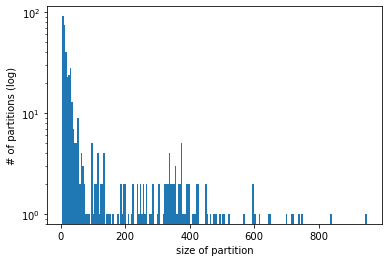

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
part_sizes=[len(x) for x in finished_partitions]
plt.hist(part_sizes,bins=200,log=True)
plt.ylabel('# of partitions (log)')
plt.xlabel('size of partition');

In [11]:
# supporting functions and pre-computations for plotting 2D-partitions 

def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

def plot_rects(df, ax, rects, column_x, column_y, edgecolor='grey', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)
    
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

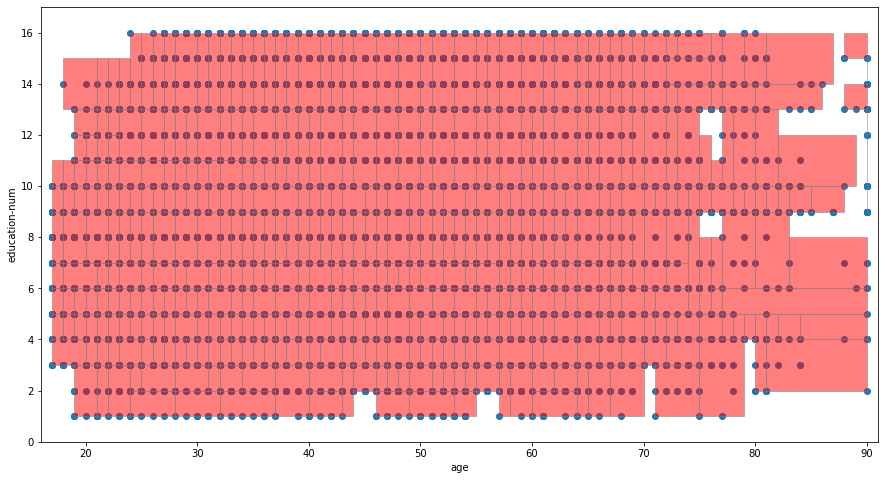

In [12]:
# Details of plotting function plot_rects has been skipped in the slide: Check the Jupyter notebook
plt.figure(figsize=(15,8))
ax = plt.subplot()
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
# we can also plot the datapoints themselves
plt.scatter(df[column_x], df[column_y])

### Generating the k-anonymous dataset

> So far we have identified the partition boundaries, along which to group the data items.
> * We need to aggregate data within the partitions, to create the k-anonymous dataset.

In [13]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [14]:
# Caution: I have tested it with other feature_columns choices and the code is brittle and it breaks.
# It serves the pedagogical purpose, but you may have to fix/reimplement for general purpose use.
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column        
    rows = []
    for i, partition in enumerate(partitions):
        #if i % 100 == 1:
        #    print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,
            })
            rows.append(values.copy())
       
    return pd.DataFrame(rows)

In [15]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn=build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)\
      .sort_values(feature_columns+[sensitive_column])
dfn

,age,education-num,income,count
605,17.0,4.000000,<=50k,5
110,17.0,5.000000,<=50k,36
111,17.0,6.000000,<=50k,198
0,17.0,7.200599,<=50k,334
120,17.0,9.000000,<=50k,14
...,...,...,...,...
726,90.0,9.000000,>50k,4
736,90.0,10.545455,<=50k,9
737,90.0,10.545455,>50k,2
772,90.0,14.000000,<=50k,2


#### Ungraded task 

<b>Ungraded Task 8.1.i</b>: Generate k-anonymous, l-diverse dataset. 

Hint: You need minor modification to how/when partitioning is done.

<b>Ungraded Task 8.1.ii</b>: For a dataset of your choice, train a ML model (of your choice) with the raw data versus the k-anonymyzed data and compare their performances (you may use default parameter choices, or try to optimize for each case). 

Note: When using k-anonymyzed data to train, the test data could still be the way the original "raw" data was. 

<b>Ungraded Task 8.2</b>: Generate differentially private data from the census dataset, using the same set of features and sensitive columns. Benchmark the performance of models trained with different parameter choices, comparing with the model built using the original (non-noisy) data. 

Hint: There are only two categories for the sensitive (income) data.

![anon](pics/anon.png)